# Laboratorium 2 (2 pkt)

Celem drugiego laboratorium jest zapoznanie się oraz zaimplementowanie algorytmów uczenia aktywnego. Zaimplementowane algorytmy będą testowane z wykorzystaniem wcześniej przygotowanych środowisk: *FrozenLake* i *CliffWorld*.

Dołączenie standardowych bibliotek

In [1]:
import random
import matplotlib.pyplot as plt


Dołączenie bibliotek ze środowiskami

In [2]:
from env.FrozenLakeMDP import frozenLake
from env.CliffWorldMDP import CliffWorld


## Zadanie 1 - Q-Learning (0.5 pkt)

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu Q-Learning. Algorytm aktualizuje funkcję wartości stanu-akcji zgodnie ze wzorem:
\begin{equation}
        Q(s_t, a_t) = Q(s_t, a_t) + \alpha[r_{t+1} + \gamma \text{max}_a Q(s_{t + 1}, a) - Q(s_t, a_t)]
\end{equation}
</p>

In [3]:
from collections import defaultdict

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #
        # INSERT CODE HERE to get maximum possible value for a given state
        #
        q_values = []
        for action in possible_actions:
            q_values.append(self.get_qvalue(state, action))

        max_value = max(q_values)
        return max_value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value for the given state and action
        #

        updated_qvalue = (1 - learning_rate) * self.get_qvalue(state, action) + \
                                    (learning_rate*(reward + gamma * self.get_value(next_state)))
        self.set_qvalue(state, action, updated_qvalue)


    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best possible action in a given state (remember to break ties randomly)
        #
        actions_qvalues_dict = {}
        for action in possible_actions:
            actions_qvalues_dict[action] = self.get_qvalue(state, action)

        best_q_avlue = max(list(actions_qvalues_dict.values()))
        best_actions = []
        for action in actions_qvalues_dict:
            if actions_qvalues_dict[action] == best_q_avlue:
                best_actions.append(action)

        best_action = random.choice(best_actions)
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon
        
        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        #        
        if random.random() >= epsilon:
            chosen_action = self.get_best_action(state)
            
        else:
            chosen_action = random.choice(possible_actions)

        return chosen_action

    def turn_off_learning(self):
        """
        Function turns off agent learning.
        """
        self.epsilon = 0
        self.alpha = 0


 Czas nauczyć agenta poruszania się po dowolnym środowisku:

In [4]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()
    path = []

    done = False

    while not done:
        # get agent to pick action given state state.
        
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)

        #
        # INSERT CODE HERE to train (update) agent for state
        #
        agent.update(state, action, reward, next_state)
        path.append(state)
        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward, path

Czas przetestować naszego agenta w środowisku *Frozen Lake*

In [5]:
def get_map(environment, hole):
    map = {}
    for state in environment.get_all_states():
        if environment.is_terminal(state):
            location = tuple(environment.state_to_xy(state))
            map[location] = hole
        else:
            location = tuple(environment.state_to_xy(state))
            map[location] = 0
    return map

In [6]:
environment = frozenLake("8x8")
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=environment.get_possible_actions)

map_train = get_map(environment,15000)
for i in range(10000):
    total_reward, path = play_and_train(environment, agent)
    for state in path:
        location = environment.state_to_xy(state)
        map_train[location] += 1

agent.turn_off_learning()
map_play = get_map(environment, 15)
for i in range(10):
    total_reward, path = play_and_train(environment, agent)
    print(total_reward)
    for state in path:
        location = environment.state_to_xy(state)
        map_play[location] += 1

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [7]:
import pandas as pd
import plotly.express as px

def plot_result(map):
    series_map = pd.Series(list(map.values()),index=pd.MultiIndex.from_tuples(map.keys()))
    df_map = series_map.unstack().fillna(0)
    fig = px.imshow(df_map)
    fig.show()

In [8]:
plot_result(map_train)
plot_result(map_play)

oraz w środowisku *Cliff World*.

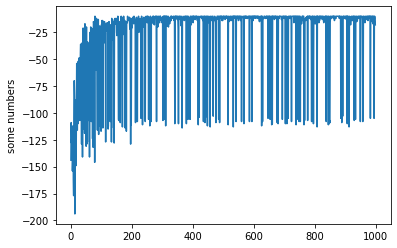

In [9]:
environment = CliffWorld()
agent = QLearningAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                       get_legal_actions=environment.get_possible_actions)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent)[0])

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()

## Zadanie 2 - SARSA (0.5 pkt)

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu SARSA. Algorytm aktualizuje funkcję wartości stanu-akcji zgodnie ze wzorem:
Q(s_t, a_t) = Q(s_t, a_t) + \alpha[r_{t+1} + \gamma Q(s_{t + 1}, a_{t + 1}) - Q(s_t, a_t)]

</p>

In [10]:

class SARSAAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    # ---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #
        # INSERT CODE HERE to get maximum possible value for a given state
        #
        values = []
        for action in possible_actions:
            values.append(self.get_qvalue(state, action))

        return max(values)

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * Q(s', a'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #
        # INSERT CODE HERE to update value for the given state and action
        #

        next_action = self.get_action(next_state)
        updated_qvalue = (1 - learning_rate) * self.get_qvalue(state, action) + \
                                    (learning_rate*(reward + gamma * self.get_qvalue(next_state, next_action)))
        self.set_qvalue(state, action, updated_qvalue)
        
        # function returns selected action for next state
        return next_action

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best possible action in a given state (remember to break ties randomly)
        #
        actions_qvalues_dict = {}
        for action in possible_actions:
            actions_qvalues_dict[action] = self.get_qvalue(state, action)

        best_q_avlue = max(list(actions_qvalues_dict.values()))
        best_actions = []
        for action in actions_qvalues_dict:
            if actions_qvalues_dict[action] == best_q_avlue:
                best_actions.append(action)

        best_action = random.choice(best_actions)
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        #    
        if random.random() > epsilon:
            chosen_action = self.get_best_action(state)

        else:
            chosen_action = random.choice(possible_actions)

        return chosen_action

    def turn_off_learning(self):
        """
        Function turns off agent learning.
        """
        self.epsilon = 0
        self.alpha = 0

 Czas nauczyć agenta poruszania się po dowolnym środowisku:

In [11]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()

    done = False
    action = agent.get_action(state)

    while not done:
        # get agent to pick action given state state.

        next_state, reward, done, _ = env.step(action)

        # train (update) agent for state
        action = agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward

Czas przetestować naszego agenta w środowisku *Cliff World*.

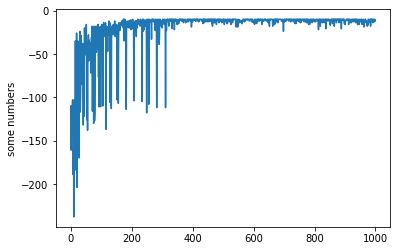

In [12]:
environment = CliffWorld()
agent = SARSAAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=environment.get_possible_actions)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent))

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()

## Zadanie 3 - Expected SARSA (1 pkt)

<p style='text-align: justify;'>
Celem ćwiczenie jest zaimplementowanie algorytmu Expected SARSA. Algorytm aktualizuje funkcję wartości stanu-akcji zgodnie ze wzorem:
\begin{equation}
        Q(s_t, a_t) = Q(s_t, a_t) + \alpha[r_{t+1} + \gamma \sum_a \pi(a|s_{t + 1}) Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}
</p>

In [13]:
import random
from collections import defaultdict


class ExpectedSARSAAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #
        # INSERT CODE HERE to get maximum possible value for a given state
        #
        q_values = []
        for action in possible_actions:
            q_values.append(self.get_qvalue(state, action))

        max_value = max(q_values)
        return max_value


    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * \sum_a \pi(a|s') Q(s', a))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to update value for the given state and action
        #
        def get_greedy(max_value):
            greedy = 0
            for next_action in self.get_legal_actions(next_state):
                if self.get_qvalue(next_state, next_action) == max_value:
                    greedy += 1
            return greedy


        sum_pi  = 0
        max_value = self.get_value(next_state)
        greedy = get_greedy(max_value)
        non_greedy_prob = epsilon / len(self.get_legal_actions(next_state))
        greedy_prob = ((1 - epsilon) / greedy) + non_greedy_prob
        for next_action in self.get_legal_actions(next_state):
            if self.get_qvalue(next_state, next_action) == max_value:
                sum_pi += greedy_prob * self.get_qvalue(next_state, next_action)
            else:
                sum_pi += non_greedy_prob * self.get_qvalue(next_state, next_action)

        updated_qvalue = (1 - learning_rate) * self.get_qvalue(state, action) + \
                                    (learning_rate*(reward + gamma * sum_pi))
        self.set_qvalue(state, action, updated_qvalue)
        

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #
        # INSERT CODE HERE to get best possible action in a given state (remember to break ties randomly)
        #
        actions_qvalues_dict = {}
        for action in possible_actions:
            actions_qvalues_dict[action] = self.get_qvalue(state, action)

        best_q_avlue = max(list(actions_qvalues_dict.values()))
        best_actions = []
        for action in actions_qvalues_dict:
            if actions_qvalues_dict[action] == best_q_avlue:
                best_actions.append(action)

        best_action = random.choice(best_actions)
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #
        # INSERT CODE HERE to get action in a given state (according to epsilon greedy algorithm)
        # 
        if random.random() > epsilon:
            chosen_action = self.get_best_action(state)

        else:
            chosen_action = random.choice(possible_actions)     

        return chosen_action

    def turn_off_learning(self):
        """
        Function turns off agent learning.
        """
        self.epsilon = 0
        self.alpha = 0
    

 Czas nauczyć agenta poruszania się po dowolnym środowisku:

In [14]:
def play_and_train(env, agent):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    state = env.reset()
    path = []

    done = False

    while not done:
        # get agent to pick action given state state.
        
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)

        #
        # INSERT CODE HERE to train (update) agent for state
        #
        agent.update(state, action, reward, next_state)
        path.append(state)
        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward, path

In [15]:
def get_map(environment, hole):
    map = {}
    for state in environment.get_all_states():
        if environment.is_terminal(state):
            location = tuple(environment.state_to_xy(state))
            map[location] = hole
        else:
            location = tuple(environment.state_to_xy(state))
            map[location] = 0
    return map

Czas przetestować naszego agenta w środowisku *Frozen Lake*

In [16]:
environment = frozenLake("8x8")
agent = ExpectedSARSAAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                       get_legal_actions=environment.get_possible_actions)


map_train = get_map(environment,15000)
for i in range(10000):
    total_reward, path = play_and_train(environment, agent)
    for state in path:
        location = environment.state_to_xy(state)
        map_train[location] += 1

agent.turn_off_learning()
map_play = get_map(environment, 15)
for i in range(10):
    total_reward, path = play_and_train(environment, agent)
    print(total_reward)
    for state in path:
        location = environment.state_to_xy(state)
        map_play[location] += 1


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [17]:
import pandas as pd
import plotly.express as px

def plot_result(map):
    series_map = pd.Series(list(map.values()),index=pd.MultiIndex.from_tuples(map.keys()))
    df_map = series_map.unstack().fillna(0)
    fig = px.imshow(df_map)
    fig.show()

In [18]:
plot_result(map_train)
plot_result(map_play)

Czas przetestować naszego agenta w środowisku *Cliff World*.

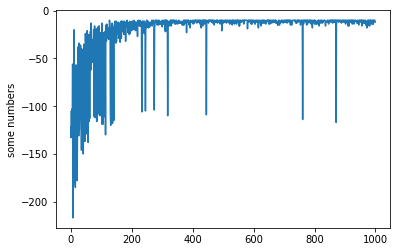

In [19]:
environment = CliffWorld()
agent = ExpectedSARSAAgent(alpha=0.1, epsilon=0.1, discount=0.99,
                   get_legal_actions=environment.get_possible_actions)

rewards = []
for i in range(1000):
    rewards.append(play_and_train(environment, agent)[0])

plt.plot(rewards)
plt.ylabel('some numbers')
plt.show()